# An Introduction to Variationnal AutoEncoders

Colab notebook can be found here : https://colab.research.google.com/drive/17ZVjA7oDy1LkxnFmNYQYGZhvOVQ7_AZ6

## Loading the model

In [0]:
%matplotlib inline
from fastai.datasets import URLs, untar_data
from fastai.vision import *

import matplotlib.pyplot as plt

# We download MNIST data
path = untar_data(URLs.MNIST)

# We add transforms
tfms = get_transforms(do_flip=False)

# We load the data
data = (ImageList.from_folder(path)
        .split_by_rand_pct(valid_pct=0.2, seed=42)
        .label_from_folder()
        .add_test_folder()
        .transform(tfms = tfms, size=64)
        .databunch())

In [0]:
# Function to create a Convolutionnal layer with batch norm and ELU activation
def conv_layer(ni, nf, ks=4, stride=2,padding = 1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding = padding),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.ELU())

class VAE_ELU(nn.Module):
    """Variational Autoencoder with spatial broadcast decoder.
    Shape:
        - Input: :math:`(N, C_{in}, H_{in}, W_{in})`
        - Output: :math:`(N, C_{in}, H_{in}, W_{in})`
    """
    def __init__(self, im_size, decoder='sbd'):
        super(VAE, self).__init__()
        enc_convs = [conv_layer(3,64)]
        enc_convs.extend([conv_layer(64,64) for i in range(3)])
        self.enc_convs = nn.ModuleList(enc_convs)

        self.fc = nn.Sequential(nn.Linear(in_features=1024, out_features=128),
                                nn.ELU(),
                                nn.Linear(in_features=128, out_features=64),
                               nn.ELU(),
                               nn.Linear(in_features=64, out_features=20))

        if decoder == 'deconv':
            self.dec_linear = nn.Linear(in_features=10, out_features=256)
            dec_convs = [nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                            kernel_size=4, stride=2, padding=1)
                         for i in range(4)]
            self.dec_convs = nn.ModuleList(dec_convs)
            self.decoder = self.deconv_decoder
            self.last_conv = nn.ConvTranspose2d(in_channels=64, out_channels=3,
                                                kernel_size=4, stride=2,
                                                padding=1)

        elif decoder == 'sbd':
            # Coordinates for the broadcast decoder
            self.im_size = im_size
            x = torch.linspace(-1, 1, im_size)
            y = torch.linspace(-1, 1, im_size)
            x_grid, y_grid = torch.meshgrid(x, y)
            # Add as constant, with extra dims for N and C
            self.register_buffer('x_grid', x_grid.view((1, 1) + x_grid.shape))
            self.register_buffer('y_grid', y_grid.view((1, 1) + y_grid.shape))

            dec_convs = [conv_layer(12,64, stride = 1, ks = 3),
                         conv_layer(64,64, stride = 1, ks = 3)]
            self.dec_convs = nn.ModuleList(dec_convs)
            self.decoder = self.sb_decoder
            self.last_conv = nn.Conv2d(in_channels=64, out_channels=3,
                                       kernel_size=3, padding=1)

    def encoder(self, x):
        batch_size = x.size(0)
        for module in self.enc_convs:
            x = F.relu(module(x))

        x = x.view(batch_size, -1)
        x = self.fc(x)

        return torch.chunk(x, 2, dim=1)

    def deconv_decoder(self, z):
        x = F.relu(self.dec_linear(z)).view(-1, 64, 2, 2)
        for module in self.dec_convs:
            x = module(x)
        x = self.last_conv(x)

        return x

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def sb_decoder(self, z):
        batch_size = z.size(0)
        # View z as 4D tensor to be tiled across new H and W dimensions
        # Shape: NxDx1x1
        z = z.view(z.shape + (1, 1))

        # Tile across to match image size
        # Shape: NxDx64x64
        z = z.expand(-1, -1, self.im_size, self.im_size)

        # Expand grids to batches and concatenate on the channel dimension
        # Shape: Nx(D+2)x64x64
        x = torch.cat((self.x_grid.expand(batch_size, -1, -1, -1),
                       self.y_grid.expand(batch_size, -1, -1, -1), z), dim=1)

        for module in self.dec_convs:
            x = F.relu(module(x))
        x = self.last_conv(x)

        return x
      
    def encode(self,x):
        mu, logvar = self.encoder(x)
        z = self.sample(mu,logvar)
        
        return z
      
    def decode(self,z):
        
        x_rec = self.decoder(z)
        return x_rec

    def forward(self, x):
        batch_size = x.size(0)
        mu, logvar = self.encoder(x)
        z = self.sample(mu, logvar)
        x_rec = self.decoder(z)
        
        kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum(dim=-1).mean()
        mse_loss = F.mse_loss(x_rec, x, reduction='none').view(batch_size, -1)
        mse_loss = mse_loss.sum(dim=-1).mean()
        
        output = {"mse": mse_loss, "kl":kl, "x_rec":x_rec}

        return output

In [0]:
# Classic VAE with ReLU and without batch norm
class VAE(nn.Module):
    """Variational Autoencoder with spatial broadcast decoder.
    Shape:
        - Input: :math:`(N, C_{in}, H_{in}, W_{in})`
        - Output: :math:`(N, C_{in}, H_{in}, W_{in})`
    """
    def __init__(self, im_size, decoder='sbd'):
        super(VAE, self).__init__()
        enc_convs = [nn.Conv2d(in_channels=3, out_channels=64,
                               kernel_size=4, stride=2, padding=1)]
        enc_convs.extend([nn.Conv2d(in_channels=64, out_channels=64,
                                    kernel_size=4, stride=2, padding=1)
                          for i in range(3)])
        self.enc_convs = nn.ModuleList(enc_convs)

        self.fc = nn.Sequential(nn.Linear(in_features=1024, out_features=256),
                                nn.ReLU(),
                                nn.Linear(in_features=256, out_features=128),
                                nn.ReLU(),
                                nn.Linear(in_features=128, out_features=20))

        if decoder == 'deconv':
            self.dec_linear = nn.Linear(in_features=10, out_features=256)
            dec_convs = [nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                            kernel_size=4, stride=2, padding=1)
                         for i in range(4)]
            self.dec_convs = nn.ModuleList(dec_convs)
            self.decoder = self.deconv_decoder
            self.last_conv = nn.ConvTranspose2d(in_channels=64, out_channels=3,
                                                kernel_size=4, stride=2,
                                                padding=1)

        elif decoder == 'sbd':
            # Coordinates for the broadcast decoder
            self.im_size = im_size
            x = torch.linspace(-1, 1, im_size)
            y = torch.linspace(-1, 1, im_size)
            x_grid, y_grid = torch.meshgrid(x, y)
            # Add as constant, with extra dims for N and C
            self.register_buffer('x_grid', x_grid.view((1, 1) + x_grid.shape))
            self.register_buffer('y_grid', y_grid.view((1, 1) + y_grid.shape))

            dec_convs = [nn.Conv2d(in_channels=12, out_channels=64,
                                   kernel_size=3, padding=1),
                         nn.Conv2d(in_channels=64, out_channels=64,
                                   kernel_size=3, padding=1)]
            self.dec_convs = nn.ModuleList(dec_convs)
            self.decoder = self.sb_decoder
            self.last_conv = nn.Conv2d(in_channels=64, out_channels=3,
                                       kernel_size=3, padding=1)

    def encoder(self, x):
        batch_size = x.size(0)
        for module in self.enc_convs:
            x = F.relu(module(x))

        x = x.view(batch_size, -1)
        x = self.fc(x)

        return torch.chunk(x, 2, dim=1)

    def deconv_decoder(self, z):
        x = F.relu(self.dec_linear(z)).view(-1, 64, 2, 2)
        for module in self.dec_convs:
            x = F.relu(module(x))
        x = self.last_conv(x)

        return x

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def sb_decoder(self, z):
        batch_size = z.size(0)
        # View z as 4D tensor to be tiled across new H and W dimensions
        # Shape: NxDx1x1
        z = z.view(z.shape + (1, 1))

        # Tile across to match image size
        # Shape: NxDx64x64
        z = z.expand(-1, -1, self.im_size, self.im_size)

        # Expand grids to batches and concatenate on the channel dimension
        # Shape: Nx(D+2)x64x64
        x = torch.cat((self.x_grid.expand(batch_size, -1, -1, -1),
                       self.y_grid.expand(batch_size, -1, -1, -1), z), dim=1)

        for module in self.dec_convs:
            x = F.relu(module(x))
        x = self.last_conv(x)

        return x
      
    def encode(self,x):
        mu, logvar = self.encoder(x)
        z = self.sample(mu,logvar)
        
        return z
      
    def decode(self,z):
        
        x_rec = self.decoder(z)
        return x_rec

    def forward(self, x):
        batch_size = x.size(0)
        mu, logvar = self.encoder(x)
        z = self.sample(mu, logvar)
        x_rec = self.decoder(z)

        kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum(dim=-1).mean()
        mse_loss = F.mse_loss(x_rec, x, reduction='none').view(batch_size, -1)
        mse_loss = mse_loss.sum(dim=-1).mean()
        
        output = {"mse" :mse_loss, "kl" : kl, "x_rec" : x_rec}

        return output

In [0]:
# Loss function : Mean squared error + kl
def loss(output,y,beta = 2):
    mse = output["mse"]
    kl = output["kl"]
    
    l = mse + beta * kl
    return l

In [0]:
# We initiate the model
model = VAE(im_size=64)

# We wrap it in a Fastai Learner
learner = Learner(data,model,loss_func = loss)

In [175]:
# We download the model
!wget https://github.com/DanyWind/X-AI/raw/master/lesson_2_neural_networks/model/full_model.pth

# We load the trained model
PATH = Path("/content")
learner = learner.load(PATH/"full_model")

--2019-05-28 11:52:09--  https://github.com/DanyWind/X-AI/raw/master/lesson_2_neural_networks/model/full_model.pth
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DanyWind/X-AI/master/lesson_2_neural_networks/model/full_model.pth [following]
--2019-05-28 11:52:10--  https://raw.githubusercontent.com/DanyWind/X-AI/master/lesson_2_neural_networks/model/full_model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6563812 (6.3M) [application/octet-stream]
Saving to: ‘full_model.pth.4’

full_model.pth.4    100%[===================>]   6.26M  --.-KB/s    in 0.1s    

2019-05-28 11:52:12 (51.2 MB/s) -

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Training the model

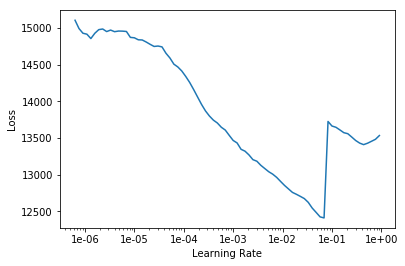

In [0]:
learner.model.cuda()

learner.recorder.plot()

In [0]:
learner.fit_one_cycle(2,1e-3,wd=1e-4)

epoch,train_loss,valid_loss,time
0,370.899078,356.194855,01:47
1,317.967072,274.186646,01:45


In [0]:
learner.fit_one_cycle(2,1e-3,wd=1e-4)

epoch,train_loss,valid_loss,time
0,342.337280,301.914795,01:48
1,300.159943,253.714691,01:47


In [0]:
learner.fit_one_cycle(2,1e-3,wd=1e-4)

epoch,train_loss,valid_loss,time
0,324.591797,335.857208,01:45
1,284.810974,241.087753,01:48


In [0]:
learner.fit_one_cycle(2,1e-3,wd=1e-4)

epoch,train_loss,valid_loss,time
0,313.561920,297.432953,01:47
1,282.826569,231.753067,01:45


In [0]:
learner.fit_one_cycle(2,1e-3,wd=1e-4)

epoch,train_loss,valid_loss,time
0,301.824768,260.019745,01:47
1,272.816925,226.493927,01:47


In [0]:
learner.fit_one_cycle(2,1e-3,wd=1e-4)

epoch,train_loss,valid_loss,time
0,296.667297,258.786346,01:45
1,266.205109,222.123428,01:47


In [0]:
learner.fit_one_cycle(2,1e-3,wd=1e-4)

epoch,train_loss,valid_loss,time
0,289.148621,286.370514,01:47
1,261.446106,218.090103,01:46


In [0]:
learner.fit_one_cycle(2,1e-3,wd=1e-4)

epoch,train_loss,valid_loss,time
0,284.034058,240.865784,01:45
1,260.671234,214.363495,01:49


In [0]:
learner.fit_one_cycle(2,1e-3,wd=1e-4)

epoch,train_loss,valid_loss,time
0,283.542938,250.617218,01:48
1,255.812897,211.549744,01:47


In [0]:
learner.fit_one_cycle(2,1e-3,wd=1e-4)

epoch,train_loss,valid_loss,time
0,280.915619,240.392471,01:48
1,256.816803,208.536606,01:46


In [0]:
learner.fit_one_cycle(2,1e-3,wd=1e-4)

epoch,train_loss,valid_loss,time
0,273.136963,239.847855,01:48
1,252.833069,206.432159,01:46


## Visualizing the results

In [0]:
# We put the model in the CPU
m = learner.model.cpu()

# We get one batch to test
x,y = data.one_batch()

Text(0.5, 1.0, 'Reconstructed image')

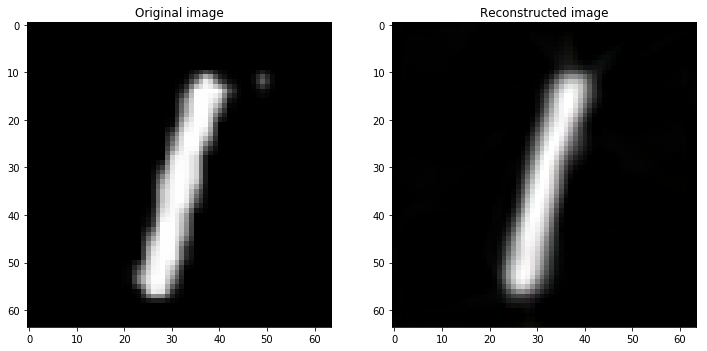

In [177]:
# We get the numpy of one reconstruction
img = m(x)["x_rec"][5].permute(1,2,0).detach().numpy()

# We get the original image
original = x[5].permute(1,2,0).numpy()

fig, ax = plt.subplots(1,2,figsize = (12,8))
ax[0].imshow(original)
ax[0].set_title("Original image")
ax[1].imshow(img)
ax[1].set_title("Reconstructed image")

## Unsupervised clustering with latent codes

In [0]:
# We get a large batch to plot
data.batch_size = 1000
x, y = data.one_batch()
z = m.encode(x)

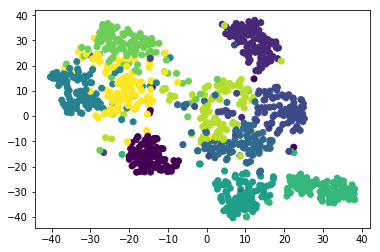

In [179]:
from sklearn.manifold import TSNE

# We project it to 2 dimensions to plot it
z_emb = TSNE(n_components=2).fit_transform(z)
plt.scatter(z_emb[:,0],z_emb[:,1], c = y)
plt.show()

## Image generation with centroid of each cluster

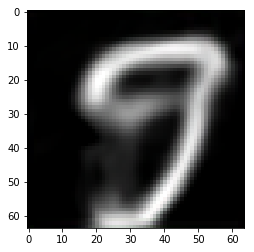

In [183]:
# We get the mean latent code of the cluster of ones
one = x[y == 7]
z_one = m.encode(one).mean(dim = 0)

# We perturb it with small Gaussian noise
z_one = z_one + 0.5 * torch.randn_like(z_one)

# We decode it
z_one = z_one.view((1,) + z_one.shape)
x_rec = m.decode(z_one)

# We show the new image
img = x_rec.squeeze(0).permute(1,2,0).detach().numpy()
plt.imshow(img)

## Analysis of latent variables with perturbations along each axis

In [0]:
# We perturb the latent variables on each variable with different magnitudes 
def plot_shades(x,model, n_z = 10,n_perturb = 13, mag_perturb = 3, ax = None):
  """Plot the reconstruction of the """
  if not ax:
    fig, ax = plt.subplots(n_z,n_perturb, figsize=(16,12))
    fig.tight_layout()
  
  # We get the latent code
  z = model.encode(x)
  
  # We create a scale of perturbations
  mag_perturb = np.abs(mag_perturb)
  scale_perturb = np.linspace(-mag_perturb,mag_perturb,n_perturb)
  
  for i in range(n_z):
    for (j,perturb) in enumerate(scale_perturb):
      # For each z_i we add a minor perturbation
      z_perturb = z.clone()
      z_perturb[0,i] += perturb
      
      # We reconstruct our image
      x_rec = model.decode(z_perturb)
      
      # We plot it in the grid
      img = x_rec.squeeze(0).permute(1,2,0).detach().numpy()
      ax[i][j].set_axis_off()
      ax[i][j].imshow(img)
      ax[i][j].set_title(f"z_{i} with {round(perturb * 1e2) / 1e2}")

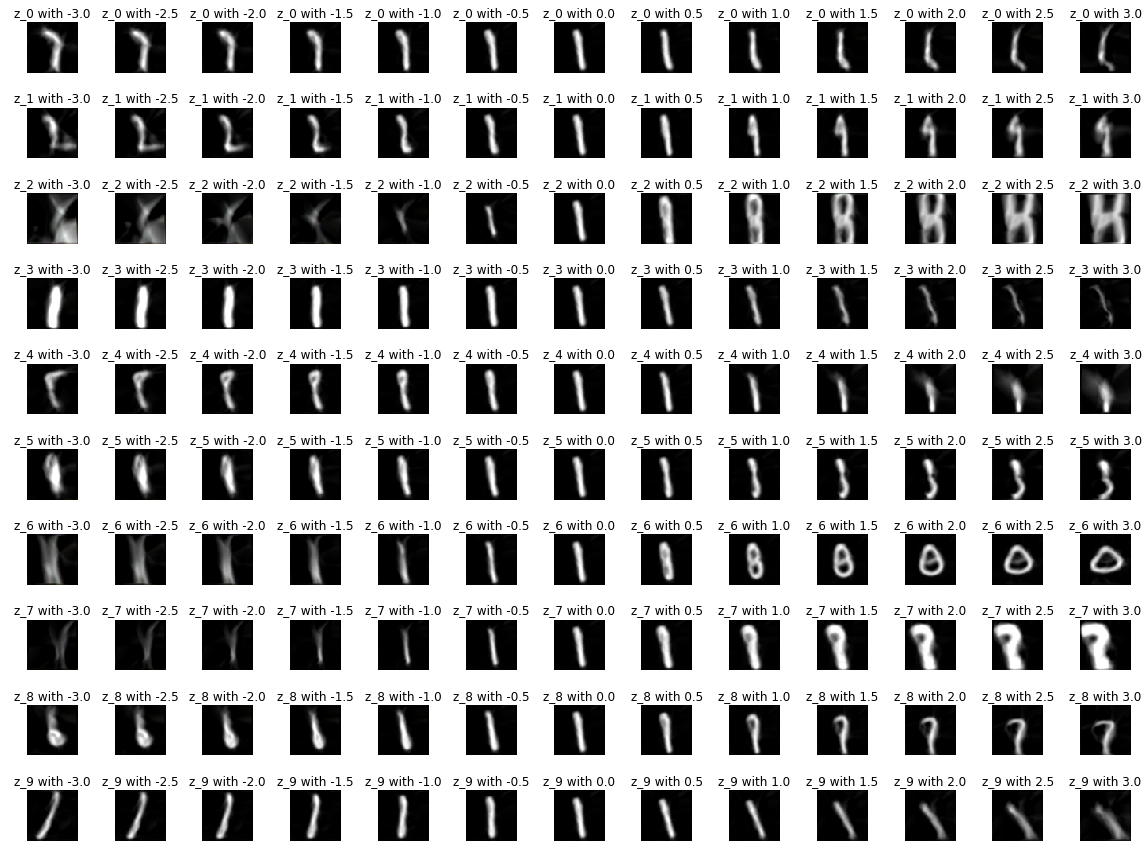

In [186]:
# We take one image
t = x[1]
t = t.view((1,) + t.shape)

# Code to hide the logging messages
import logging

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

# We plot the results
plot_shades(t,m)

logger.setLevel(old_level)